In [1]:
import torch

if torch.cuda.get_device_capability() < (7, 5):
  raise ValueError(f"You got a GPU with capability {torch.cuda.get_device_capability()}, need at least (7, 5)")
else: print("OK")

OK


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%pip install -q bitsandbytes==0.37.0 transformers==4.27.4 datasets==2.7.0 accelerate==0.18.0 loralib==0.1.1 peft==0.3.0.dev0

Note: you may need to restart the kernel to use updated packages.


#### Load model

In [4]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from accelerate import init_empty_weights, infer_auto_device_map

CACHE_DIR = '/media/tfsservices/DATA/NLP/cache/'
MODEL_NAME = "EleutherAI/gpt-neox-20B"


config = AutoConfig.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


In [5]:
device_map = infer_auto_device_map(model, dtype="float16")

In [6]:
# print(device_map)

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,        # bitsandbytes lib required (convert the loaded model into mixed-8bit quantized model.)
    # device_map='auto',
    device_map=device_map,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR)      # path to a directory in which a downloaded pretrained model
    # low_cpu_mem_usage=True,   # loads the model using ~1x model size CPU memory
    # offload_state_dict=True)  # temporarily offload the CPU state dict to the hard drive to avoid getting out of CPU RAM
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 46/46 [00:28<00:00,  1.62it/s]


#### Apply LoRA

In [8]:
# for module in model.modules():
#     if isinstance(module, bnb.nn.Linear8bitLt):
#         module.state.memory_efficient_backward = True

for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
        param.data = param.data.to(torch.float32) # cast the small parameters (e.g. layernorm) to fp32 for stability

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

# cast model outputs to float32 to unfuck the top-k sampler
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
model.embed_out = CastOutputToFloat(model.embed_out)

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [10]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=8, ## can be reduced to 8
    lora_alpha=32,
    target_modules=["query_key_value" ],
    lora_dropout=0.05, ## 0.05
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False # test,
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8650752 || all params: 20563218432 || trainable%: 0.04206905659543013


In [11]:
# model.eval()

#### Methods to calculate perplexity

In [12]:
# %pip install -q nltk spacy
# %pip install -q evaluate


In [13]:
import numpy as np

def get_next_token_prob(lm, prefix, next_token):
    
    batch = tokenizer(prefix, return_tensors='pt') 
    # print(batch) 
    next_token_id = tokenizer(next_token, return_tensors='pt').input_ids[0][0]
    # print(next_token_id)

    return _get_next_token_prob(lm, batch.input_ids, next_token_id)

def _get_next_token_prob(lm, input_ids_prefix, next_token_id):
    probs = []
    with torch.cuda.amp.autocast():
        # outputs = lm.forward(**batch)
        outputs = lm.forward(input_ids=input_ids_prefix)
        probs = outputs.logits[0, -1].softmax(-1)
        # probs = outputs.softmax(-1)

    # print(probs)
    return probs[next_token_id].detach().item()

In [14]:
get_next_token_prob(model, "Hi", ",")

0.20421144366264343

In [15]:
def get_line_log_prob(lm, prefix, line, min_logprob=np.log(10 ** -50.)):

    input_ids_prefix = tokenizer(prefix, return_tensors='pt').input_ids
    input_ids_line = tokenizer(line, return_tensors='pt').input_ids

    # print(input_ids_line)
    line_log_prob = 0
    
    for i, next_id in enumerate(input_ids_line[0]):

        # print(f"iteration: {i}")

        next_id_unsq = torch.unsqueeze(next_id, dim=-1)
        prob = _get_next_token_prob(lm, input_ids_prefix=input_ids_prefix, 
                                        next_token_id=next_id_unsq)
        if (prob == 0):
            line_log_prob += min_logprob
            continue
        
        log_prob = np.log(prob)
        if (log_prob < min_logprob):
            line_log_prob += min_logprob
            continue
            
        line_log_prob += log_prob

        # print(next_id_unsq)
        # print(input_ids_prefix)
        input_ids_prefix = torch.concat((input_ids_prefix, torch.unsqueeze(next_id_unsq, dim=-1)), 1)

        # print(input_ids_prefix)
        # with torch.cuda.amp.autocast():
        #     input_ids_prefix = model.generate(input_ids=input_ids_prefix, 
        #                                       min_length=1,
        #                                       max_new_tokens=1, 
        #                                       do_sample=True, 
        #                                       pad_token_id=tokenizer.eos_token_id)

            # print(f"new prefix ids: {input_ids_prefix}")
        
    # generated = tokenizer.batch_decode(input_ids_prefix.detach().cpu().numpy(), skip_special_tokens=True)[0]
    # print(f"text: {generated}")

    return line_log_prob

In [16]:
get_line_log_prob(model, "Hi ", ", my name is")


-16.01954630077261

In [17]:
def perplexity(lm, prefix, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above

    """
    corp_log_prob = 0
    
    N = 0
    # cnt = 0
    # cnt_total = len(lines)
    for line in lines:

        # cnt += 1
        # print(f"{cnt}/{cnt_total}")
        
        N += len(line.split()) + 1
        line_log_prob = get_line_log_prob(lm, prefix, line, min_logprob)
            
        corp_log_prob += line_log_prob
    
    return np.exp(-corp_log_prob/N) 

In [18]:
# perplexity(model, "Hi", [" my namy is Yury!", ", Jhon.", "! Are you ok?"])

In [19]:
import pandas as pd

# df = pd.read_csv('datasets/armm_large_1.csv')
# df = pd.read_csv('datasets/armm_small.csv')
# df = pd.read_csv('datasets/wm.csv')
# df = pd.read_csv('datasets/wm_large.csv')
df = pd.read_csv('datasets/wm_large_01.csv')

CATEGORY = 'Purchase Inquiry'
# CATEGORY = 'Listing Inquiry'

# CATEGORY = 'Requirement'
# CATEGORY = 'Listing'
df = df[df['tag']==CATEGORY]

# # ADAPTER_NAME = "adapters/gpt-neox-20B-wm_list_resp_sm"

df.head()

,text,tag
0,"Hi {Client}, \n\nHope all is well. I am Stacey...",Purchase Inquiry
1,Hi \nThank you for contacting CAE. What's the ...,Purchase Inquiry
2,"Hi {MakeModel}, \nThank you for your inquiry. ...",Purchase Inquiry
3,"Hi {Client}, \n\nThank you for contacting CAE....",Purchase Inquiry
4,"Hi Sir, \n\nHope this mail finds you well, I r...",Purchase Inquiry


In [20]:
prefix = 'Q: Generate\nA: '

In [21]:
def create_prompt_column(raw):

    # return f"Q: Generate for {raw['tag']}:\nA: {raw['text']}\n###\n"
    # return f"Q: Generate response\nA: {raw['text']}\n###\n"
    return f"{prefix}{raw['text']}\n###\n"

In [22]:
df['prompt'] = df.apply(create_prompt_column, axis=1)

In [23]:
df.head()

,text,tag,prompt
0,"Hi {Client}, \n\nHope all is well. I am Stacey...",Purchase Inquiry,"Q: Generate\nA: Hi {Client}, \n\nHope all is w..."
1,Hi \nThank you for contacting CAE. What's the ...,Purchase Inquiry,Q: Generate\nA: Hi \nThank you for contacting ...
2,"Hi {MakeModel}, \nThank you for your inquiry. ...",Purchase Inquiry,"Q: Generate\nA: Hi {MakeModel}, \nThank you fo..."
3,"Hi {Client}, \n\nThank you for contacting CAE....",Purchase Inquiry,"Q: Generate\nA: Hi {Client}, \n\nThank you for..."
4,"Hi Sir, \n\nHope this mail finds you well, I r...",Purchase Inquiry,"Q: Generate\nA: Hi Sir, \n\nHope this mail fin..."


In [24]:
train_dataset_path = './datasets/train.csv'
df.to_csv(train_dataset_path)

In [25]:
dummy_lines = df[:3]['text']

test_dataset_path = './datasets/test.csv'

df[:3].to_csv(test_dataset_path)

In [26]:
from datasets import load_dataset

# dataset_path = './datasets/wm_ext.csv'

data_files = {"train": train_dataset_path, "test": test_dataset_path}
# dataset = load_dataset("csv", data_files=dataset_path)
dataset = load_dataset("csv", data_files=data_files)
tokenizer.pad_token = tokenizer.eos_token

dataset = dataset.map(lambda samples: tokenizer(samples['prompt']), batched=True)


Using custom data configuration default-d37823ad77e97c80


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting data files #0: 100%|██████████| 1/1 [00:00<00:00, 481.88obj/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dataset csv downloaded and prepared to /home/tfsservices/.cache/huggingface/datasets/csv/default-d37823ad77e97c80/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 197.55ba/s]


In [27]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'tag', 'prompt', 'input_ids', 'attention_mask'],
        num_rows: 151
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'tag', 'prompt', 'input_ids', 'attention_mask'],
        num_rows: 3
    })
})


In [28]:
# from torch.utils.data import DataLoader
# import transformers
# from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

# training_loader = DataLoader(dataset, batch_size=4, 
#                                     collate_fn=DataCollatorForLanguageModeling(tokenizer, mlm=False),
#                                     pin_memory=True)

# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
# loss_fn = nn.CrossEntropyLoss()
            

In [29]:


# def train_one_epoch(epoch_index, tb_writer):
#     running_loss = 0.
#     last_loss = 0.

#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(training_loader):
#         # Every data instance is an input + label pair
#         inputs, labels = data

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()
#         if i % 1000 == 999:
#             last_loss = running_loss / 1000 # loss per batch
#             print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0.

#     return last_loss

In [30]:
# EPOCHS = 5

# best_vloss = 1_000_000.

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))

#     # Make sure gradient tracking is on, and do a pass over the data
#     model.train(True)
#     avg_loss = train_one_epoch(epoch_number, writer)

#     # We don't need gradients on to do reporting
#     model.train(False)

#     running_vloss = 0.0
#     for i, vdata in enumerate(validation_loader):
#         vinputs, vlabels = vdata
#         voutputs = model(vinputs)
#         vloss = loss_fn(voutputs, vlabels)
#         running_vloss += vloss

#     avg_vloss = running_vloss / (i + 1)
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

#     # Log the running loss averaged per batch
#     # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.flush()

#     # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

#     epoch_number += 1

In [31]:
import evaluate
metric = evaluate.load("accuracy")

metric.compute(predictions=[0,1,2,3], references=[0,1,2,3])


{'accuracy': 1.0}

In [32]:
import evaluate
from transformers import EvalPrediction


def compute_metrics_and_save(p: EvalPrediction):
    
    # print(p)
    print("evaluating perplexity...")
    perp = perplexity(model, prefix, dummy_lines)
    # perp = 1.1 # dummy
    
    # print(trainer.state.epoch)
    num = round(trainer.state.epoch, 1)
    print(f"epoch: {num}")
    print(f"perplexity: {perp}")
    
    adapter_name = f"training/epoch-{num}"
    model.save_pretrained(adapter_name)

    return {'perplexity': perp}

In [33]:
import transformers
from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

trainer = Trainer(
    model=model, 
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    args=TrainingArguments(
        per_device_train_batch_size=4, 
        per_device_eval_batch_size=4, 
        gradient_accumulation_steps=4,
        # warmup_steps=10,
        warmup_ratio=0.25,
        # num_train_epochs=1,
        num_train_epochs=5,
        learning_rate=2e-4, 
        fp16=True,
        evaluation_strategy="epoch",
        # eval_steps=5,
        # evaluation_strategy="steps",
        logging_strategy="steps",
        logging_steps=5,
        output_dir = 'training'
    ),
    
    compute_metrics=compute_metrics_and_save,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False))

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Perplexity
0,3.079000,2.714511,37.698899
2,2.301500,2.374248,27.371267
2,1.810700,2.190292,21.404234
4,1.722400,2.103082,19.135360


evaluating perplexity...
evaluating perplexity...
evaluating perplexity...
evaluating perplexity...
evaluating perplexity...


TrainOutput(global_step=45, training_loss=2.0689868291219073, metrics={'train_runtime': 1470.8135, 'train_samples_per_second': 0.513, 'train_steps_per_second': 0.031, 'total_flos': 1.785982164000768e+16, 'train_loss': 2.0689868291219073, 'epoch': 4.74})

In [ ]:
# trainer.train()
trainer.state.epoch
print(round(trainer.state.epoch,1))

1.4


In [34]:
trainer.state.log_history

[{'loss': 3.079,
  'learning_rate': 8.333333333333334e-05,
  'epoch': 0.53,
  'step': 5},
 {'eval_loss': 2.714510679244995,
  'eval_perplexity': 37.698899192616786,
  'eval_runtime': 177.6413,
  'eval_samples_per_second': 0.017,
  'eval_steps_per_second': 0.006,
  'epoch': 0.95,
  'step': 9},
 {'loss': 2.717,
  'learning_rate': 0.0001666666666666667,
  'epoch': 1.05,
  'step': 10},
 {'loss': 2.3015,
  'learning_rate': 0.00018181818181818183,
  'epoch': 1.58,
  'step': 15},
 {'eval_loss': 2.3742480278015137,
  'eval_perplexity': 27.371267475762927,
  'eval_runtime': 174.9127,
  'eval_samples_per_second': 0.017,
  'eval_steps_per_second': 0.006,
  'epoch': 2.0,
  'step': 19},
 {'loss': 1.9171,
  'learning_rate': 0.00015151515151515152,
  'epoch': 2.11,
  'step': 20},
 {'loss': 1.8107,
  'learning_rate': 0.00012121212121212122,
  'epoch': 2.63,
  'step': 25},
 {'eval_loss': 2.1902918815612793,
  'eval_perplexity': 21.404233879023074,
  'eval_runtime': 174.6811,
  'eval_samples_per_second'

In [47]:
train_losses = []
x_train_losses = []

eval_losses = []
x_eval_losses = []

perplexities = []
x_perplexities = []

for data in trainer.state.log_history:
    if ('loss' in data):
        train_losses.append(data['loss'])
        x_train_losses.append(data['epoch'])

    if ('eval_loss' in data):
        eval_losses.append(data['eval_loss'])
        x_eval_losses.append(data['epoch'])

    if ('eval_perplexity' in data):
        perplexities.append(data['eval_perplexity'])
        x_perplexities.append(data['epoch'])

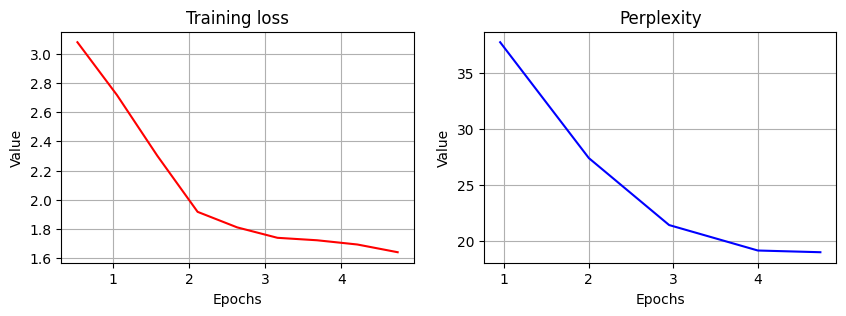

In [48]:
## plot training results
import matplotlib.pyplot as plt

# xdata = np.linspace(1, len(train_losses), len(train_losses))

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,2,1)
ax.plot(x_train_losses, train_losses, color='red')
ax.grid("on")
ax.set_title("Training loss")
ax.set_ylabel("Value")
ax.set_xlabel("Epochs")

ax = fig.add_subplot(1,2,2)
ax.plot(x_perplexities, perplexities, color='blue')
ax.grid("on")
ax.set_title("Perplexity")
ax.set_ylabel("Value")
ax.set_xlabel("Epochs")

plt.show()

In [40]:
# trainer.state.log_history

In [41]:
# import transformers
# from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

# trainer = Trainer(
#     model=model, 
#     train_dataset=dataset['train'],
#     args=TrainingArguments(
#         per_device_train_batch_size=4, 
#         gradient_accumulation_steps=4,
#         # per_device_train_batch_size=1, 
#         # gradient_accumulation_steps=1,
#         warmup_steps=10, 
#         # warmup_steps=2, 
#         # max_steps=20, 
#         # max_steps=10, 
#         # max_steps=43, ## for large dataset
#         # max_steps=40, 
#         max_steps=50, 
#         learning_rate=2e-4, 
#         fp16=True,
#         logging_steps=5, 
#         save_steps=10,
#         output_dir='outputs_wm',
#         overwrite_output_dir=True,
#     ),
#     tokenizer=tokenizer,
#     data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False))

# model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
# trainer.train()

#### Save LoRA adapter

In [ ]:
# ADAPTER_NAME = "lora_adapters-6.7b"
# ADAPTER_NAME = "lora_adapters-13b"
# ADAPTER_NAME = "adapters/gpt-j-6B-armm"
# ADAPTER_NAME = "adapters/gpt-j-6B-wm"

# ADAPTER_NAME = "adapters/gpt-neox-20B-armm_req"
# ADAPTER_NAME = "adapters/gpt-neox-20B-armm_list"

# model.save_pretrained(ADAPTER_NAME)

#### Test generation

In [57]:
# best_epoch = np.argmax(perplexities)
# print(f"best epoch: {best_epoch}")


In [58]:
from peft import PeftModel, PeftConfig

# adapter_name = f"training/gpt-neox-20B-wm-purch-resp-{best_epoch}"
# adapter_name = f"training/gpt-neox-20B-wm-purch-resp-2"
# adapter_name = f"training/gpt-neox-20B-wm-purch-resp-1"
adapter_name = f"training/epoch-4.0"
# model = PeftModel.from_pretrained(model, adapter_name, device_map={"":0})
model = PeftModel.from_pretrained(model, adapter_name, device_map={"":0})

AttributeError: _hf_hook

In [33]:
# model.inference_mode=True
# model.config.use_cache = False

In [44]:
# def generate_text(max_length = 150):
    
#     batch = tokenizer("Q: Generate response\nA: ", return_tensors='pt').to('cuda')

#     # with torch.no_grad():
#     with torch.cuda.amp.autocast():
#         output_tokens = model.generate(**batch, min_length=30, max_length=max_length, do_sample=True, pad_token_id=tokenizer.eos_token_id)

#     print('\n\n', tokenizer.decode(output_tokens[0].cpu().numpy()))

In [49]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = stops
        self.ENCOUNTERS = encounters

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        stop_count = 0
        for stop in self.stops:
            stop_count = (stop == input_ids[0]).sum().item()

        if stop_count >= self.ENCOUNTERS:
            return True
        return False    

stop_words_ids = [tokenizer(stop_word, return_tensors='pt')['input_ids'].squeeze() for stop_word in ["###"]]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids, encounters=1)])

In [50]:
def generate(prompt: str, max_length=250):

    batch = tokenizer(prompt, return_tensors="pt").to('cuda')

    # input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    # with torch.no_grad():
    with torch.cuda.amp.autocast():
        # outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_length=max_length, do_sample=True, )
        outputs = model.generate(**batch,
                                # early_stopping=True, 
                                # num_beams=6,
                                # num_beam_groups = 3,
                                # no_repeat_ngram_size = 4,
                                # temperature=0.9,
                                top_k=10,
                                # top_p=0.8,
                                # penalty_alpha=0.6,
                                # repetition_penalty = 1.05,
                                do_sample=True,

                                max_length = max_length,
                                pad_token_id=tokenizer.eos_token_id,
                                stopping_criteria=stopping_criteria,
                                
                                # use_cachе=True,
                                # output_scores=True,
                                # return_dict_in_generate=True).detach()
        )
        generated = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
        print(f"tokens: {len(generated.split())}")
        print(f"text: {generated}")

In [51]:
# generate(prompt='Q: Generate Requirement \nA:', max_length=250)
# generate(prompt='Q: Generate response\nA:', max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)
# generate(prompt='Q: Generate text  \nA:', max_length=250)
# generate_marketing()
# generate(prompt='Hi {Client}:', max_length=250)

tokens: 59
text: Q: Generate
A: Hi {Client},

This is {Trader}.  
Thank you for your inquiry on {MakeModel}.  
Please note that this is a very old one, but we still have a few left in our website.  
The price for a new one is {Price} {Currency} per unit.  The delivery time is {Delivery} {Time}
Do you have any other questions?

{Signature}
###


In [52]:
# generate(prompt='Q: Generate Requirement \nA:', max_length=250)
# generate(prompt='Generate text in 150 tokens for Purchase Inquiry with questions:', max_length=250)
# generate(prompt='Q: Generate response\nA:',max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 62
text: Q: Generate
A: Hi {Client}, 
I just spoke with {proprietor} about your inquiry for the {MakeModel}.  He mentioned he'd like to know what you're going to use it for and what price range you're considering.  I'm happy to assist you with this.  If you have any questions or need help with anything, don't hesitate to call me.  

{EquipDetails}

Best Regards,
{Signature}
###


In [53]:
# generate(prompt='Q: Generate Listing \nA:', max_length=450)
# generate(prompt='Generate text for Purchase Inquiry :', max_length=250)
# generate(prompt='Q: Generate response\nA:', max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 30
text: Q: Generate
A: {Client}, 

I received your email on {MakeModel} and I'm sorry to hear that you need to sell the system. 
{EquipDetails} 
Do you know the price? 
{Signature}
###


In [54]:
# generate(prompt='Q: Generate response\nA:', max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 65
text: Q: Generate
A: Hello {Client}, 

Thank you for your inquiry. Are you looking to buy or sell? 
I will be in the CAE office for the next week, if you have any questions for me, please leave them in the chat window when I am in the office so that I will have a way to help you before I leave.

Best Regards,
{Signature}
###


In [55]:
# generate(prompt="Q: Generate response\nA:", max_length=512)
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 64
text: Q: Generate
A: Hi {Client}, 
How are you doing? My name is {Trader}, I work here at CAE. I am calling you today for {MakeModel}, is it still available for sale? 
I see you are requesting for a quotation, can you please check with your manager and get back to me with the details. 
Thanks and hope to here from you soon. 

{Signature}
###


In [56]:
# generate(prompt="Q: Generate response\nA:", max_length=512)
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 76
text: Q: Generate
A: Hi {Client}, 

Thank you for your interest in our {Category} equipment. Please let me explain more about this unit, so we can answer your questions more accurately. 

This model is a used one, but it's working properly. 
There is no warranty on the machine, since it's a used one. 
There is a photo of the equipment below; if you have any questions, please do not hesitate to contact me.

{EquipDetails}

Regards,
{Signature}
###


In [77]:
# generate(prompt="Dear {FirstName} ", max_length=250)
# generate(prompt='Q: Generate for Purchase Inquiry \nA:', max_length=250)

In [78]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [79]:
# generate(prompt="Requirement: Hi {FirstName} ", max_length=200)
# generate(prompt="Requirement: ", max_length=200)
# generate(prompt="Hi {FirstName} ", max_length=250)
# generate(prompt="Q: Generate for Purchase Inquiry \nA: ", max_length=450)

In [80]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [81]:
# generate(prompt="Inquiry: Hi {FirstName} ", max_length=200)